In [100]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_8259/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt, log
sns.set_style("darkgrid")

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  
from pandas.plotting import scatter_matrix


In [102]:
_prints = False

In [114]:
local = True

path = '../data/' 
hotels = pd.read_csv('../data/features_hotels.csv') # à tester, sans ces données

if local : 
    data = pd.read_csv(path+"data.csv")
else :
    url = 'https://drive.google.com/file/d/10sNct4HjylkBudNAQNfvMpI7qgvsspwj/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    data = pd.read_csv(path)
    
data = data.merge(hotels, on=['hotel_id','city'])
data_test = pd.read_csv(path+'test_set.csv') # ignore index 
data_test['request_number'] = 1
data_test = data_test.merge(hotels, on=['hotel_id','city']) 

for avatar in np.unique(data_test['avatar_id']):
    data_test.loc[data_test['avatar_id'] == avatar, 'request_number'] = data_test['order_requests'].loc[data_test['avatar_id']== avatar] - min(data_test['order_requests'].loc[data_test['avatar_id']== avatar])+1

data = data.drop(index = data.loc[data.avatar_id == 134].index)
data.tail()

,city,date,language,mobile,request_number,avatar_id,hotel_id,price,stock,group,brand,parking,pool,children_policy
487145,amsterdam,40,finnish,1,1,103126,30,109,88,Accar Hotels,Navatel,1,0,0
487146,amsterdam,40,cypriot,1,1,124787,30,107,88,Accar Hotels,Navatel,1,0,0
487147,amsterdam,40,hungarian,1,1,124846,30,99,88,Accar Hotels,Navatel,1,0,0
487148,amsterdam,39,lithuanian,0,1,124889,30,105,84,Accar Hotels,Navatel,1,0,0
487149,amsterdam,40,luxembourgish,1,1,125160,30,101,88,Accar Hotels,Navatel,1,0,0


In [104]:
data.head()

,city,date,language,mobile,request_number,avatar_id,hotel_id,price,stock,group,brand,parking,pool,children_policy
1,valletta,32,bulgarian,1,1,167,55,100,49,Boss Western,Boss Western,1,0,0
2,valletta,32,hungarian,0,1,179,55,100,49,Boss Western,Boss Western,1,0,0
3,valletta,5,danish,1,1,197,55,129,0,Boss Western,Boss Western,1,0,0
4,valletta,36,danish,1,1,203,55,110,64,Boss Western,Boss Western,1,0,0
5,valletta,33,dutch,0,1,205,55,106,53,Boss Western,Boss Western,1,0,0


In [113]:
data.loc[data.language == 'french'].loc[data.city == 'copenhagen'].loc[data.date >=17]

,city,date,language,mobile,request_number,avatar_id,hotel_id,price,stock,group,brand,parking,pool,children_policy
87425,copenhagen,17,french,0,1,5572,422,401,25,Morriott International,Corlton,0,1,0
87947,copenhagen,17,french,0,1,5572,849,206,16,Morriott International,CourtYord,0,0,0
88469,copenhagen,17,french,0,1,5572,96,140,14,Boss Western,Boss Western,0,0,0
88991,copenhagen,17,french,0,1,5572,487,173,34,Morriott International,CourtYord,0,0,0
89513,copenhagen,17,french,0,1,5572,711,146,14,Boss Western,Boss Western,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156459,copenhagen,17,french,0,1,5572,922,258,16,Yin Yang,Royal Lotus,0,1,0
156967,copenhagen,17,french,0,1,5572,830,93,20,Independant,Independant,0,0,0
157442,copenhagen,17,french,0,1,5572,358,232,19,Accar Hotels,Marcure,0,0,0
157964,copenhagen,17,french,0,1,5572,329,249,20,Morriott International,Morriot,1,0,0


> ajouter une variable écart de temps

> fusionner children policy 1 et 2

> hotel_ID en QT

> transfos sur le prix

> transfos sur autres variables QT

In [59]:
for col in ['city', 'language', 'avatar_id', 'hotel_id', 'group', 'brand','children_policy','mobile','parking','pool'] :
    data[col] = pd.Categorical(data[col],ordered=False)
    data_test[col] = pd.Categorical(data_test[col],ordered=False)
    
data.dtypes

Unnamed: 0            int64
index                 int64
hotel_id           category
group              category
brand              category
city               category
parking            category
pool               category
children_policy    category
price                 int64
stock                 int64
date                  int64
language           category
mobile             category
avatar_name          object
dtype: object

In [7]:
# colQT = ['request_number', 'stock', 'date','price']
# colBool = ['mobile', 'pool', 'parking']
# colQL = ['city', 'language', 'group', 'brand', 'children_policy']

In [60]:
colQT = ['stock', 'date','price']
colBool = ['mobile', 'pool', 'parking']
colQL = ['city', 'language', 'group', 'brand', 'children_policy']

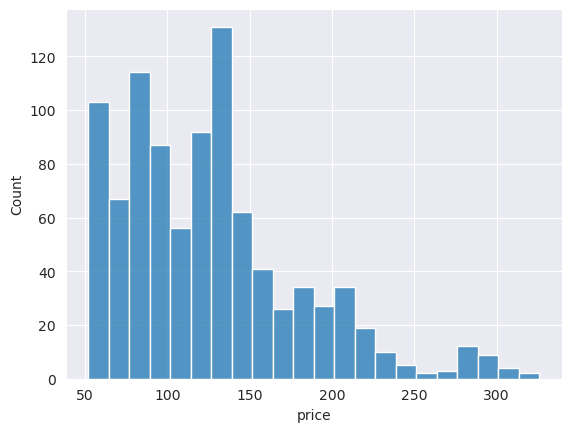

In [63]:
if _prints :
    plt.figure()
    sns.histplot(data['price'])
    plt.show()

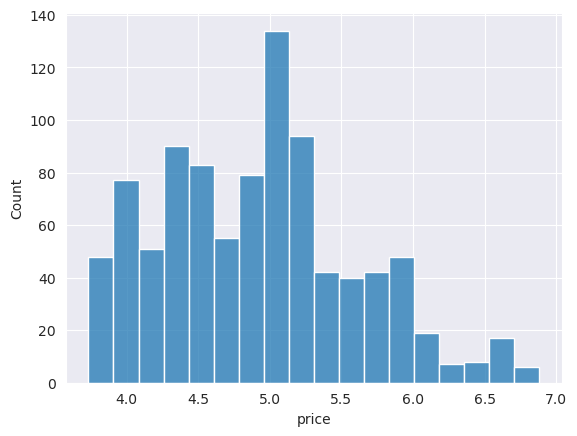

In [64]:
if _prints :
    plt.figure()
    sns.histplot(data['price'].map(lambda x: x**(1/3)))
    plt.show()

In [65]:
transfo = True
if transfo :
    data['SRprice'] = data['price'].map(lambda x: x**(1/3))

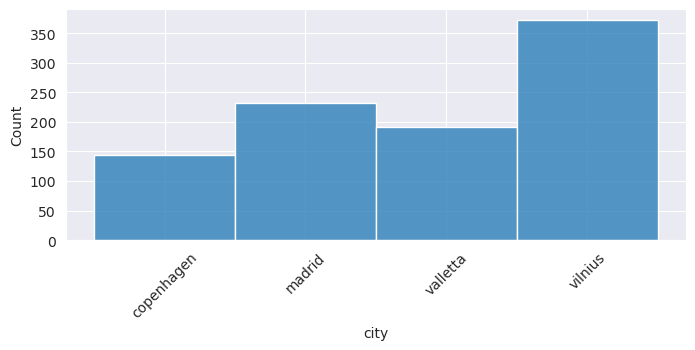

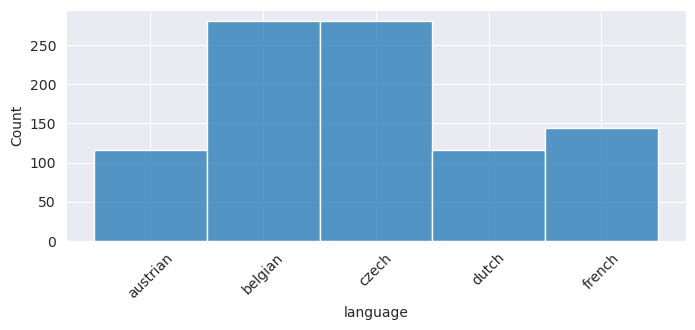

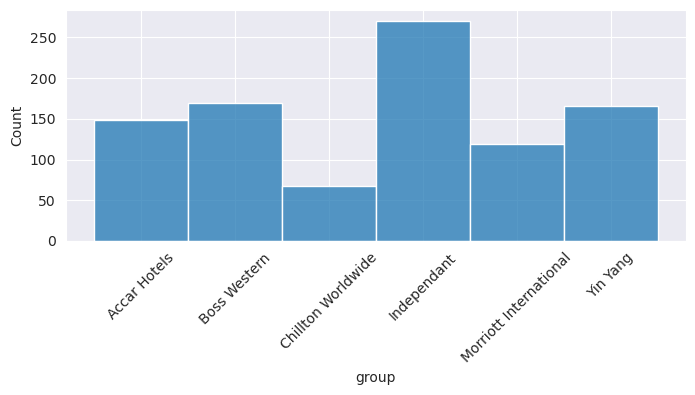

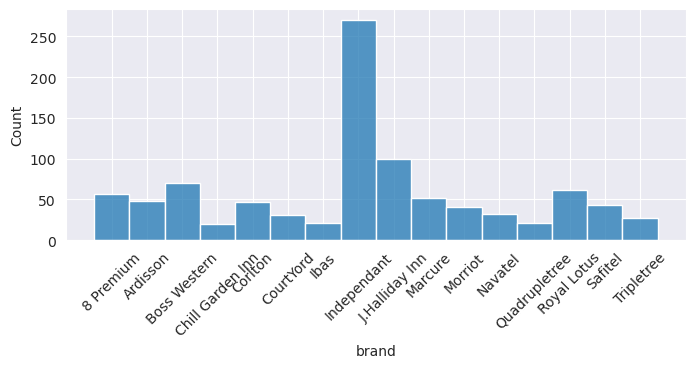

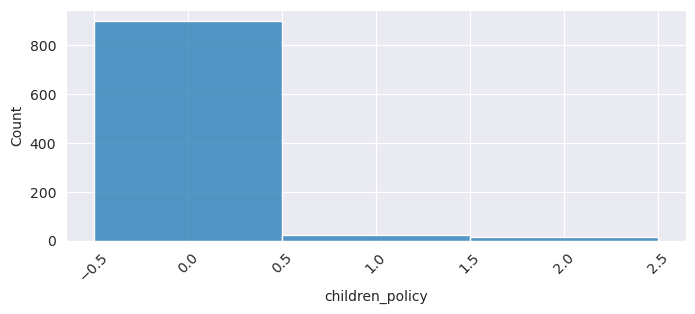

In [66]:
if _prints :
    for col in colQL:
        plt.figure(figsize=(8,3))
        sns.histplot(data[col])
        plt.xticks(rotation=45)
        plt.show()

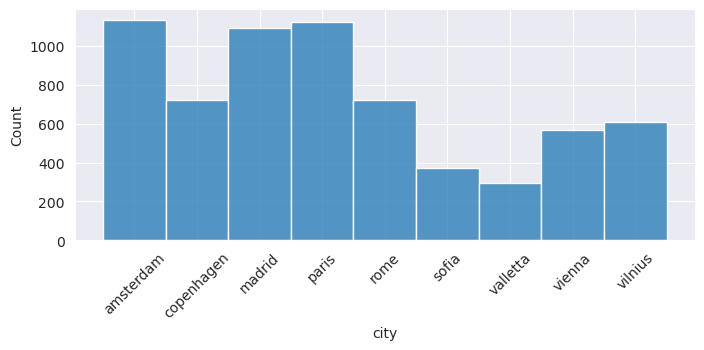

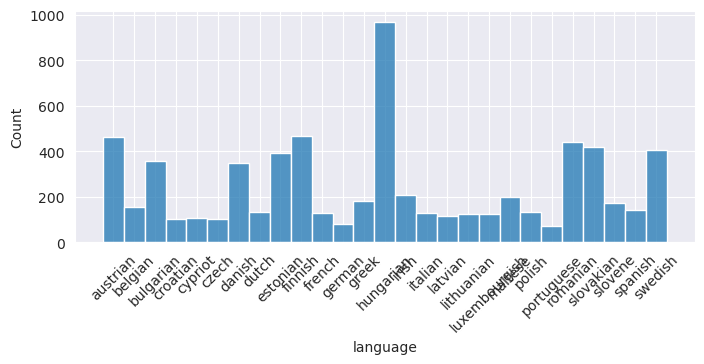

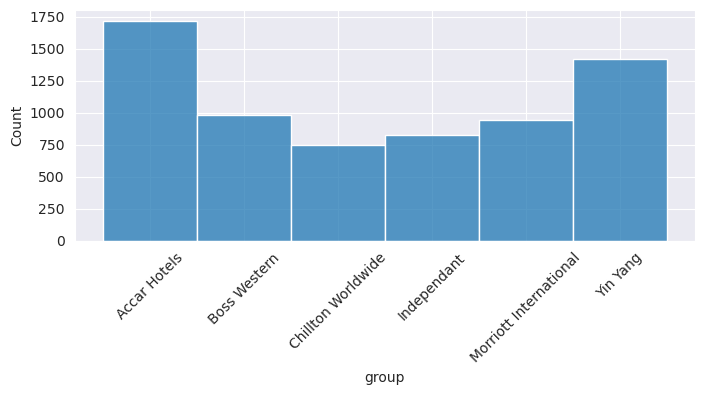

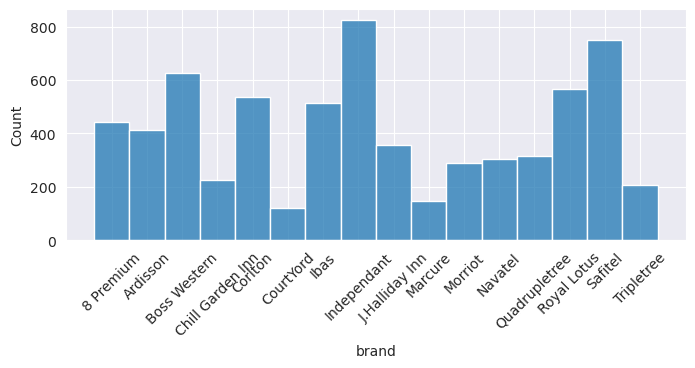

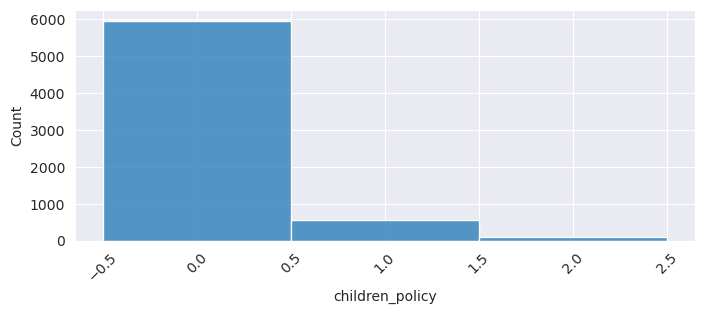

In [67]:
if _prints :
    for col in colQL:
        plt.figure(figsize=(8,3))
        sns.histplot(data_test[col])
        plt.xticks(rotation=45)
        plt.show()

In [28]:
if _prints :
    scatter_matrix(data[colQT], alpha=0.2, figsize=(10, 10), diagonal='kde')
    plt.tight_layout()
    plt.show()

In [29]:
if _prints :
    scatter_matrix(data_test[colQT], alpha=0.2, figsize=(10, 10), diagonal='kde')
    plt.tight_layout()
    plt.show()

QT vs QL

In [30]:
# dataDum = pd.get_dummies(data[['city','language','mobile','hotel_id','group','brand','parking','pool','children_policy']])
# del dataDum['city_amsterdam']
# del dataDum['language_austrian']
# del dataDum['mobile_0']
# del dataDum['hotel_id_0']
# del dataDum['group_Accar Hotels']
# del dataDum['brand_8 Premium']
# del dataDum['parking_0']
# del dataDum['pool_0']
# del dataDum['children_policy_0']

# # on Test Set

# dataDum_test = pd.get_dummies(data_test[['city','language','mobile','hotel_id','group','brand','parking','pool','children_policy']])
# del dataDum_test['city_amsterdam']
# del dataDum_test['language_austrian']
# del dataDum_test['mobile_0']
# del dataDum_test['hotel_id_0']
# del dataDum_test['group_Accar Hotels']
# del dataDum_test['brand_8 Premium']
# del dataDum_test['parking_0']
# del dataDum_test['pool_0']
# del dataDum_test['children_policy_0']

In [68]:
dataDum = pd.get_dummies(data[colQL])

# on Test Set

dataDum_test = pd.get_dummies(data_test[colQL])

In [82]:
for i in dataDum.columns:
    if i not in dataDum_test.columns:
        dataDum_test[i] = 0
dataDum_test = dataDum_test[dataDum.columns]

In [83]:
dataDum_test.head()

,city_copenhagen,city_madrid,city_valletta,city_vilnius,language_austrian,language_belgian,language_czech,language_dutch,language_french,group_Accar Hotels,...,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree,children_policy_0,children_policy_1,children_policy_2
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [85]:
dataDum.head()

,city_copenhagen,city_madrid,city_valletta,city_vilnius,language_austrian,language_belgian,language_czech,language_dutch,language_french,group_Accar Hotels,...,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree,children_policy_0,children_policy_1,children_policy_2
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [86]:
dataQT = data[colQT[:-1]]
dataQT_test = data_test[colQT[:-1]]

In [87]:
dataBool = data[colBool]
dataBool_test = data_test[colBool]

In [88]:
df = pd.concat([dataDum,dataQT, dataBool],axis=1)
df_test = pd.concat([dataDum_test,dataQT_test, dataBool_test],axis=1)
df.head()

,city_copenhagen,city_madrid,city_valletta,city_vilnius,language_austrian,language_belgian,language_czech,language_dutch,language_french,group_Accar Hotels,...,brand_Safitel,brand_Tripletree,children_policy_0,children_policy_1,children_policy_2,stock,date,mobile,pool,parking
0,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,68,30,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,41,30,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,24,30,0,0,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,73,30,0,1,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,74,30,0,0,0


In [89]:
df_test.head()

,city_copenhagen,city_madrid,city_valletta,city_vilnius,language_austrian,language_belgian,language_czech,language_dutch,language_french,group_Accar Hotels,...,brand_Safitel,brand_Tripletree,children_policy_0,children_policy_1,children_policy_2,stock,date,mobile,pool,parking
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,46,21,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,36,18,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,44,20,1,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,36,18,1,0,1
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,30,16,0,0,1


In [90]:
# variable à expliquer réelle
if transfo :
    Y = data['SRprice']
else :
    Y = data['price']

In [91]:
# # séparation pour les tests et tunner les modèles
# X_train,X_test,Y_train,Y_test=train_test_split(df,Y,test_size=.25,random_state=11) #25% pour le test_size
# submit = False

In [92]:
# séparation pour submit
X_train = df
X_test = df_test
Y_train = Y
Y_test = None
submit = True

In [93]:
# standardisation des données
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)  
X_stand_train = scaler.transform(X_train)  
# Meme transformation sur le test
X_stand_test = scaler.transform(X_test)

# Boosting

https://xgboost.readthedocs.io/en/stable/python/python_intro.html

In [94]:
# définition des paramètres
boost = GradientBoostingRegressor()
# apprentissage
rfFit = boost.fit(X_train,Y_train)

In [95]:
if not submit:
# erreur de prédiction sur le test
    1-rfFit.score(X_test,Y_test)

In [96]:
# prédiction
y_pred = rfFit.predict(X_test)
if not submit:
    print("MSE =",mean_squared_error(y_pred,Y_test))
    print("R2 =",r2_score(Y_test,y_pred))

# Random Forest

In [ ]:
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500,
                               max_depth=None,
                               min_samples_split=2, min_samples_leaf=1, 
                               max_features='auto', max_leaf_nodes=None,
                               bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train,Y_train)
print(1-rfFit.oob_score_)

In [ ]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
if not submit:
# erreur de prévision sur le test
    1-rfOpt.score(X_test,Y_test)

In [ ]:
# prévision
y_pred = rfOpt.predict(X_test)
if not submit :
    print("MSE=",mean_squared_error(y_pred,Y_test))
    print("R2=",r2_score(Y_test,y_pred))

# Export predictions

In [99]:
y_pred

array([94.63521436, 93.78885949, 92.71306095, ..., 76.19972213,
       76.25047647, 76.25047647])

In [98]:
# save
if transfo:
    y_pred = y_pred**3
if submit :
    sub = pd.DataFrame(y_pred)
    sub.to_csv('boosting.csv',index=True, header=['price'], index_label = 'index')

In [ ]:
sns.histplot(y_pred)